In [1]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.config.list_physical_devices('GPU'))

TF Version:  2.15.0
TF Hub version:  0.16.1
Eager mode enabled:  True
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:

def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = tf.io.decode_image(
      tf.io.read_file(image_path),
      channels=3, dtype=tf.float32)[tf.newaxis, ...]
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

13925/13925 [==============================] - 0s 0us/step

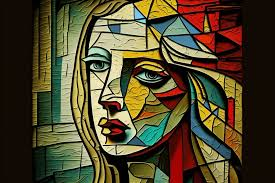

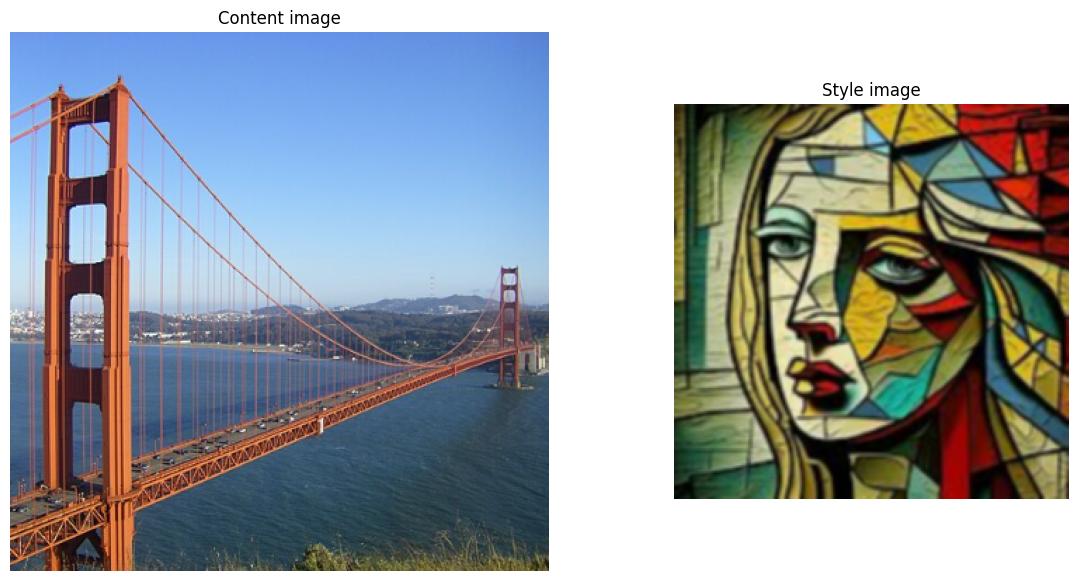

In [7]:


content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'
style_image_url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUTEhIWFhUXGB0aGRgYGB4dHhodIhYYHxgdGBsYHyggHRsmGxcaIjMhJSkrLi4uFx8zODMtOCgtLisBCgoKDg0OGxAQGy0mICYrMTUuNy0tLS0vLS0tLS0tLS8tLS0tLS0vLS0tLS01LS01Mi0tLS0tLS0tLS0tLS0tLv/AABEIALcBEwMBIgACEQEDEQH/xAAcAAACAgMBAQAAAAAAAAAAAAAABgQFAQMHAgj/xABOEAACAQIEAwQFCAcFBgQHAQABAgMAEQQSITEFQVEGEyJhMkJxgZEHFCNSYqGxwTNDcoKSstEkU6Lh8DREc7PC8SVjk9IVFlRkg7TTCP/EABoBAAIDAQEAAAAAAAAAAAAAAAADAgQFAQb/xAA1EQABAwIDBAkEAgEFAAAAAAABAAIDESEEEjFBUXGBEyIyYZGhscHwBRTR4SMzBkJSYnLx/9oADAMBAAIRAxEAPwDi9FAoqCmiiiihCj2q4wY2sLee/wCX5VBw6DKx8jVzw3lYE/AfkaXK6yGi68Y6IiQak/Q359X9/LnVNgkZmCquZmNgKYuLr9KuxvB1v60nT+lbOy2Ayr3lvERe5Gw3AH43qLX5Y6lQd2iq04FljWQsoDMALLfcEixY9F6c6kR4MkajOeQdjlHtA5e6rPiMf0WGQDTMN7biM20Hv31qfhMKRa6jyzX1+BFxXMxLapTn5TRVMHBlsDIQTyBsFGvJfRA9up86mNwsONfBCniZm0zeZ6KOQ3JO2wDBhMKRbMNTzJ1Y8go0t05gDpaqvEzDEyKtx83VrIAReZx6TAMRmVdgBfrz0rFzifnkrEZBVWiyyyg4ZMiKuVGca6+k4XqdLX5DzqxTsysYjR7zTSHwI5OUD1pHUeqCfaxIF9yL9sYsC+GIRn6+IdEQeeUMXc/Zst+tUE3F2mLx4Tvp5HH0+ISM3y6+GIbRra4u1gBfc61xhkfoKD5qU05QpvhcsIWSHDw3DzBV8TD0gmYEBAdLgEsdq9YHBYriIy4SJFww0OIxCg5zexyJYjry5aldqt+C9gZJRE2NKxYdLZMKjXzHkZXHpHf0b+RGt+j4eEKAAAAosoUWCjkFXkK4crO8/PE+S5Ulcd418mkGDjSefEPKglAlWNQhCkHVB4i1jYkfVva1N3B+zeChAaCBCDYrIRnJuNCrG5AI5i29NHaEgxKLj9NHp++N/fS0i/Mjb/dGOn/25J/5BJ/cJ+qdI4vDYjEYYyRk1GoFqj8qMc8ccoY7boV77S444bDTTgDMq2W+pzkhY7WJFgzXsPPao3A+G/NcPAhUsyoQ4FtWchn1YgXzC2p99HatWklwmHVb3kM7i9hliAy5jY+Eu68vVqyUTHUtEyHkEbbn4s5ufcK8+TlhaDapJNa8APVaAu8qt4lw1HZWjcw4lReJxZjl3yOqkl49NrGw22rPBOMCR3hliCTAXaJctn3DSRE2DqRluCcy2setWhhIBtcrvrqVN9CDa5sd7n2dDQdpMXgJLd/ioopIzdHjkzSI3I3QX0+qRrTInCUZCCRvFSR703iveCouGU1SIC0ZeMQkpHI6L41LWV2AFja9gLXudq0S4xDo2Hl/gB/6rULxhMzqX71y7MHRGAkLMWvlIBU3Oot7K2vxA7iCT97Ko+JNegyurdvnRbUErDA2kpNALZa8Rotfzi4smGY/tZVt7dTatOIkcDM/dKL5QMrOb9OVb1xU7XtCg/ae9/eo1qDxgT2VmCWU5rLflzJJ215dakxozUt41XMRIREZOsaf8co8qFEkkp9HvPdEqj4sb1GxuEkdgRYG1vFMhP416OAm9IxxgHW9gbDy1qLxSNomC3U6X0QDmfb0p7aVo0hZc4lyF0gdS2vlSt15fhko9K3/AKif+6o8mG6Efxr/AO6vIzHYfdXtkcC5JA9tPFdpWaQDoCsKtv8AX9KzXlDpXqhQRRRRQhYooooQsiigUUIRRRQaEKVh0+hc25b9NauuEAjLmaw/ay39wteqvDfoG9n58uQ3q74LFqDsOelyf4ufwqrMbHipNUKeMAwi/wCoP3O4/Kr7hcVsOSNhESTteyXPu/H2b1fFo7TqL7ROLdPp5tP86v8Ah8JfDBAGs0RU7C5KWAFjc7k28hXHnqBIPbK3cRwg/swJAAckknSwiYfiRUjh2E0DBbFtTprr/SpPF8Me/g0sAkp2zalogPf6XKpmFwQ5i5PNhYn4gUsGwUXiqqONqVRYI9JMQ2S/MJb6Vvbl01+tSV2zlVp0wsC3EI7sW1LOSMwHsIC+0HypvxOKEcuNxQtbDIIYtNO80voP/NYA+S0t/JpwxZ8Z3kkhRIvHmzKDmJsh8YNze52vpTYhcuOz1P6TgKNpvTlwL5MhEiF2DSkAvnhjdFPRQ5ubbXtrTAW4hBIMNDNhsndZwPmuQAZstgsTgVaSYWEjxY6W3li8n3xlaWO3HZyIxpOjNKqXWUNPJKcjFbPdnY2VhqNrMT6tSp0hoT5LhOUVU+fjXFEYlxw5wBuXeI/BnsKjJ20xKsQV4eTmubY9NdNlBuRbQe7nuUyThEAVrQpsfV8vOuwcLgVYo7Io8C7AfVHlU5sP0QFaFQjmz6Jax3GOIYiPJHh8JfMjDLO0hBV1YXCLYDw28RHtqE2KxLL/AGrFfNUYbjCgoRsfpy8sVv3qfiTy18r2/I1rSI3LDwEnxBbEN+1cWJ03sD51yKd0Qo3RclhEmuvL3XC8X2iOBxUqRMMSqIscEjPcKnp2HdWDLmfbYBQOQtAxHbrHOSUdYyd+7jW59rMC330ydo+CxNjMZiWQ5IZ0EipoVQxpd0t6ynxWIsRerHGcL7rK11eNrZJVAswPoXtoCQR5NpaxOUcb9tJLlcBmO8c6KbjLGyouB8quemLG4o/SPK46yuxA9gY1bcO7KDMF/SSHW2yqPrP0X272sPJmWJmZY0tne9r7KBbM7DoLjTmWA6kNWAwaRLlRD1YsfEx6k7MfuGg0tYXHhkXVCqdK99ylTjHZqGKFDl8KjLIw0YXa4lBGxVyb20CseSiqOZZIGyTm6nRJdgfJ/qt57GumSoSCCilSLEFtwdwRlpYbBhCcLKMy5bx5tc0d7WJO7JcKT0yncmoCNkwyO12FPwn1CbCP6RhrvG8Kha/v6f0Fe8BgO++cAZvDhm35lmFrX1/VnpWnH4J8LqA0mH67vF/VR9343XY2TNPNlkUKYo9QA2bxy7X2HXa1txWViYZcPW19nivVz/UoMZhKsO0VG0fN6WuHyZ4Yzv4QNeoNtfeKqOIgmY3IBVQLgb6nrz1q0kRYJcRA0gASQlT6IIYXsL620+/eq3Eygy5kDOMoF1Um5ueZ39tOjFHEj5VcnmbNho6m9q33VGguo7xycgCPhUTGgiwKgHyq3WKU+oEB5yMB8AKG4TmIzsWPQC1h58xThIGm6pPwj5AQwHnb1uqKLavdbsZEFkZQLAEfgK004Gt1lvYWOLTsRRRRXVFYooooQsiigUUIRRRRQhWWEA7hv2Ty86ZeEZrA6i2x/wA2OnuNUGGjthXJ+roLDXUfdamHguHJtZF9tifzt8b1RnPVPFMao3aAD5yliD/Z73BvqZZSbm+9zTFwmIjDZtSywkjy+jvp02qj48AcUuua2G3Gvrye74aVf8HhLYUKCEUxWawA0KeIsd9r7WoJ/jaq7h1ymJ4Q+KkNhpDEN7+viPLz+6pbosKPK2ixqznU7KCTp7qxBY4mTQ/oYtNPr4jzqJ29e2CMYNmnkjgX99vF/gVq40VK7S651x+Upw+CInxzZsVL11YiO46F3/wU6fIxwdRgmlZFLTSG11B8K2Ub/az/ABpO7ZOG+eyA+FJIsJGOgjBLgeWZCffTxguLQ4bAYTBJMIXfDo8sgBJhWQZ2sFBPfMXbLpoLseQZramOm8/tTOqtMPwrD4rEySNDE0EN4kuilXkuO+e1rFVsI18xJ1vU5+yfDz/umG9yKPw1rTwbiGEYJDhMZGAoCrCvd3AA+rIveE9av1Q89T/rpXCShKZ7FYEeAq8R2UpNIoYcgPFlzW0Itc2Jtapp4FiE0h4lOtthIkUgHld0B++rx3HiDDTbTxZhYX0A6ki3lWGBIsPCD5G9ug2y/D2da4ZDvXA0JeD8QVsi4vAyte2V42VvZaOTf3VvPEccnpw4Qn7OIkX7jCwHvNWyQxqBHZFW1gvhAt0C3/KtzA/60pT5CFMNCSuzkTTYniBdSt5lzLnzDWFQfVAcEdeR2rRwaI4eZ+HygNEwZsPn2eP9ZEb7lLkje6k+Vrfs7Hlx3ERa13hO994Fvrz1qR204UsuGdnOQxqzxyXylXCkix89iOYNVJYg95B205GlimtdQJD7NY+aU4uTBQxyFG0EkjB+5F+7yAgBhfMdWvdteV5eH47i5ASr4YWNiO6kup5qwaS4YdCKoezUM0AwjxFTNIheDXSTxHvcNL+1YOhOzHTUgjouFw+C4onfoGjnXwuV8M0TfVkFrML3tmBBt7bbLZAw9YVHmqMkOYdWxSy2Lxp/3mNf2IB/1s1QuJ4XFSLf52zOpzJeOMANYjdVBFwSPfV9xDgeLgue7GIjHrRWWQD7UbGx9qt7hVYvEYs2Rm7t/qSAxt7g4F9+V6vx9A/sqm8TM1HklXh2Plm8D4mVZBcMvhGo3y2XWt69noxezyXO5z7+21TuKcPhjm76VCcPJYTZdGjPqTRkagg773F9Na3cb4fPgrM7CbDNYpiANgdV7zKbWIIswFj76yscydr6Ncfm5en+k4rAuYGyxgHf+d3FLvFuGxxxNZFvlNjby1Pt1t76oOH8Wki0BzL9U/kdx+HlTRxdi0UjaG6aW2Aty63/AKUvQ8NUga6+RqMDwY/5Lq1j4Htnb0HVtw2+aveH8Uil0Hhc7htz7DzqS0Q2+7l8KWpeFgDQm9bcNxWSM5JRnXkb+Iew8/f8agYAbxlWY/qD46NxLRxGnMfOCjcV/TP7R/KKi1vx0oaRmW9idL+wda0VcYKNC89iHB0riN59UUUUVJJWKKKKELIooFFCEUGisGhCv41thH0F8nX2cqveFKuUE3b0QAQSLlgq3vbS5G1UpX+ytt6A5eY51f8ADhmQKuYnNGdiB4ZEbYWB23JFZ0unP8Jo9lq7Ux2xag8sKOQHry8hTH2eiAwoJJOWK4BPMLcC2tttyBS/2qjtivW/2UHUAevNtl0A/wBa1t7K4ETTwLKO8UG9pCWUWQnZiQNqfHHnibfQKlJIGyGu0p/4bio5MTIY3VwI0UmM5xcPKSMwGW4BGl+dRe1L58Zw+KxCoZcQ97bIgCHQnmzUyQrbwqFAHQ3sP2QB068tqUeLLn4jirHWLh5T2F+8b42t8KW6zTw/SsN1SBxqNjwiJ2F3mxRkNuZZZrV0zDdp+HYKNcOsueRVGZYVaViwADFmW4LXFtW5WpM4ZjIIsDC/EYpZoFCd0kRXJmsbCVPC2b0tSzKbHQHQ+X+UPCtdYeDRFF/Z0HK4WIhdfOrEQ6p4lJmGY0onZ+NcMxymOYIrclxCd237he1z+yb1R4zjjYB2w08ryYWRDkYu+eJrXS0qEOYybAi9wNja4pdj7aYGe6ycKUWBPgKMbAEsbFF2AJ35VUcVnido0hZsgkW0MqlXS7i6rupW/q305UwtrZKYHNcu2Ds+FvkxWMXX/wCoZwP/AFM9vfaoWJ4bOpsOIYq1t/oD8D3N6bJYvFcKLa+IHX/Mf6tXIvlS7SYvC47u8PKEVokY3RG1u49dTbblWVIyaQZYnUPetBpa01cE3NFiwLDGs/8AxIIW/lCGtYTiFvDioV8vmo0+Etq5E3b3iW3znfpFEPwSrLhU3FsYSIZ53HMhsiDrqBY+wA70n7bGMFXytA30B9QE0GJ2jT4p9bgWMJdpOIOmf0jh4UiJtt4lBbmdjVHxvsZH82lkLSzTZGIeZ2Y+VgTodvvrEXC+OxC6SxSgbrdWPxKqf8VQ8b2yx+HGXGYJAp0v4lv+9mdaUPunOHRytdfQEA+CkBHtaVI7OYb59wQxL+mwzMUI0ZXDGRNehDFQdLZTvyi4TiJkSPGSu+FxJGVcbEt45GBylMUnI3AuSLHQ7aVTdiu1i4PGl8pSCbwyqfFl18Li2+Uk8ti3WndcQuDlmlhUYvAznNImHZJWhl0BIANijbG9thtax2HZmk21uPcKoQFMwfbxolH/AMRw9kO2Kw30sD/AnL7idTsKvsLLhMcrZRFOjakXVwLBQMy7q1uRA2pGjbg0zu0OKbCSNuFZoLeTXHdnW53O9RuIdgIMj4qLiAyxqZGdAjEAC5IMRGv5mo9XaCDwRQpwx3YXCnwxCSEHfu5CFt0EbXQ353G3ntHwvZ/F4WLuYXixeH1Hc4gFSFN7qroctrnYr7LVy6Pj3FYvRxU5HRnL28rPevZ+UDio0OIPvij/AByXpmRzhQOBU3QvjPWaRyUjtNwefDLJ/ZJY4WBurESLEeeSRL+HyYLvS/JxUeql/b/lV6nyk8RC5S0ZW1rGFLW9wFUrIz/SgKmbXKoUAG2uUHQAnW1Syj/XRPhlnPVaTpurQc+KjHEzPtoPLT7zWYsDfVjf/XWvUsE172NuViB+GlYET8w5/fqVbWIU8prWQOPGv7WrFLZiPZ+ArVWW3O/v1rFTGiqPNXEoooorqgsUUUUIWRRQKK4hFYO1ZrDV1CaVI+avqT4B5Ddd9r/D30ycGRrLYPY6bIvInSym+gPMUuo39mZQSSUG224+NX/DsIM0eZRe5a9jfRbbjl4xWXLoR3n0Tgo3agf2sAjKPm6jVtSO8lvm8/jpVx2FUDEp4xZVbd9B4bdfOqftNpi1sRb5unpFh+tl6kVcdhWtiCQUJ7trC99cyDm1+fWrkP8AQOCzJv7+af8AD+KeQqQQEjXTXUGRtwejilbhbq+N4i9/0kgw6ebR4c5gP4WPupnwULBpGa95HDWDMNAiLyv9S/vpR7ESCRcPLlP0uLxE1z5rOvt2aq85/jPzv9lfZqlLENm4HsTlya6WFpQvW/OpPYzjmCXADDSDuZsxkLyI3dzDM62Z4wWC5CUzWsp11tas4bDqvDeIYckfQPImvVJQw353FN3yb8GSfhOGvmV1aQpKG1ibvZPEoY2PQqRZgSDpTY3hod/29VF7c1OCQMdg8HmVhi4E8OQsrM5sVKkhY4/E5Unkoub+VMGKiXE4rh5jw7JE065Xl0kkWOzSFIxsmVQMzG/iGg1rpHDsNG7FJYYlnQXbKos4vYSRE6lCfep0PImowLfOONyW/R4CARj/AIsurEfuAr+7U+lJ2KAiAunSSMXvblqf69f8q+evlLxAm4liCLBIysQ8iqjPz37xn0H479z4lx3DxHIWLvcgpEpdgbbNbwodfXIr52xDCaWWYixkld9T9ZyeXt62qMLdSpSPACqorBkLLmF7lc2W4HInUj/v7aYJu1krZRiLNh1FhhY2aGPLbYZNSP2s29GG7NzSwtPGjMA+Tw2JCi2dlUkZzckWuPRpk7K9neHr9LOxkAOspuUU6+GVbZoGFtnGXoxqYMchpu8R+FJzxHHWlSVp4b2g4K/p4ZsKw2ZQ2nseI5r+4UwKyuP7LxSGRP7nFSLIDcHdiwlUa8yedLnabserlnh8ceaR1kh+kUh5FdC3dZmsFLRmwJFla1ibLOH7OSIpcyLHYm7SjItraACUAuxOtgDYDWx0CHYBpNWuPAmo86oZiLdZHaXhKK7NBlZVP0qxN3scV9ssqjKVbkNxYi2l6Xzmja6kgjZgbH3EVeJx6SBjlRVJXK2UWjkTo8br4l89DroRWqDCOYhK0RWJnKodbXtfKL62tex+yelWmlzBdOyMe7KHa7aUXiLtRibASOs6j1Z0WX/E4LD3EVJh4ngX1nwLRk7vhpWA90cuYfBhVRjsLl1G1Tez8KOHWQgIxVWY/qy1xHJ+yraN5OamcpbUJL2FjspTVw/CcPmFoeKSxNyXEquntY+D/FUviHY/GRgFe6xA308BI6i5II9lJ03CsrNHOvdsjZGb6p9XN9huTctjyNTMHjcbw83hlbJfVDqh5m6HTluLHzFIdDmGZh+cRdMZj5YzlzEc/wA2XvHxyRgibDyRablbr/EtV+GxyhVBDaC1wAR9xrqPZLtvBjSIpVEU50ynVHP2Cdj9k+4mpPFex2ExLsQgUiy54zl8Vzm20a1wPaCORqqZhH1ZW0Vv7yVxDq15LliY2En0gPcR8a8z4mP662Hnf7qmYjszNk7yMLOh1ABs4U+iSOd1sffVJ3Kgm6EEbi2o9qmrLWsJsU3717m0oPAhaZ2uxI2P+uVeK9ykX029lvurxVgaLNf2iiiiiuqCxRRRQhZFFAoriEVhtqzWG2rqE6cMUZVFxsNgenXUUx4ZFBDMg2sCzBd7ciN9BoL0tyY8xQrIIhlJCj6S26k847jbrXrC9opB6EKA+ckh/ArWW6Fz7j1TDI1tipHaYEYtfCFvAul7/rZedhf4Vf8AyfX+cNcfqjsPtp1NKWOx7zYgPLlB7pR4Lrpnf6zsSbk636aU3dgLGeS507v2eunO9/iavMBbDQ7lnSUM4IT5jZjHDLJlsEjdrk9FJuQB5daUOyy93heFnkXKn9/DzMPvUfGrbteqJgMWyxj9C4zWA9IZdOZ9LnaosCZMFhF+rJhwPcRm2+zmqliOyBvPt+1oRqk41woHG46I2yyxLONNdY2VrdPpEuT7qbfkZf8A8Jg8mk/5rH86o+1My/P8GyEN3kOIiJBuCFAa1x0JNe/kfw7S8MH00qhZXXKjBR6rE3ADX8X1hUoiTHfu9x7Idqugccij7oyuxjMKtIJRvHZSWOu6kCxU6MNPZyvgfEJkwyAnu5uIyS4iaUMqlY7iyRFmFnYeIG91ViRrqL7t/wAJjKYfCRPMZcXMELPiJnyxKM0zWlcjQW0I2Jq149jcDND82hkLvHbujh43m7p1FkuYgVAAOUgsLqWHOnNs221RN1XYCFRZUQADax29wW3wNcgwgyxgkG6rqPMb13Xh8kzwqwwsqSkAMjEWjbrcscycwVBvtobgcsx3CCnEWwtif7QD55CRN7/oza9GHeGZy7ZfwSZo82UDenjgWD+bwRRsyiy7mwOY6yWvv4iTz89hS32u7OyGdcRgZGSfL4sjEXHUsOvne/upthgcEllzk6ciQB6Iu2hG55XJvavc7KujNl3uATnJ6AL4j52H515mPEyRzZ2mp9eS13RtcyhXGeI8TxMTEYvCwsx1zSQKpO2uaPKW5akk61CftFIP0UcMHnFGA3ud8zj3EV1ftRg1lWCMaNnaRTILnKI2VgbksULPGCDrY25Cy7hJMDG5vgZe8U2ZbRkK1r6FpBcdDbUWNejhxueMOLVR+3JfkYKlUvZHsfLi377EXEd7nNfM+vO+tiOddK49w6NsK6PZUygC1lVLEWa59EKdbk266VQ4jtZKRaDDKltmlbNb2Igt/itVFxDENIc+KmLkagPZUU8sqCyg676nzqLpcxqTwpdXYfpWIeesMo3uslmVcwZTYkaaXsehW+uU7itXZ6K8xhO0qNH92ZbfvKtTuKYzDE3zsXGl0/MnQioeCVkxGGkOhaRGF9DbOtr26/hVuF28Uqk/VGNDS1rg4gaj37054mQTYSHGsmd4L4bGLzeMWBJva7ZSrA8m15VXwQZHkwznP3djG314mF0YdRYjXzFXXZGQDF47DOhKyoHyA39bIbXsNe8+6l/L3awSaBoZXwso0DZc30bMBuAGUX+zVaFximdHsrbgb+RqOYVCQCfDh+2nmqjjXBrXZNuYp3+Tzti0p+bYhj3oU909zZgB6DrtmAGhtqAeeprMemtuYF7fG34GlHikTQyiRCVIIZSORBuDVrEYdszKHl3JGFxBBoV1ngsoGHhGYMoijsV8Vvo10cJcg+dvb503aPgS4qVsjBWSNCrg3BLPKCDbkO7H8Rq77NSmbCwSplIKWy2AsV8LC4F7C2h103ve41yQ/wBole7LljjvZjb9bfMo0bTqKwmvLJHEWI/K1aVAXI8fhXikZJBZwdfhoR5EVHq67ZS5sZKbWtlFj5IvQn8apa3mElgJ3Ks7VFFFFSXEUUUV1CBRQKK4hFYbY1msNtXUJt40WGDhvYDvE2U/3b73JPwqFhWHVj7AfztUrjigYKEAa94nK36t/f8AdUTBsR1+H9TVaHscylT6qQx+l2t9Gu+/pv0p2+T42mexH6Po31lpMAPe3t+rXe/1386c/k+H00l/7vl+0Kc7sKoKdKFefKHrw3FWuTkXrYDvUvodja9epz4MB9Xvx/8Aq4jL99vuqf2kw/eYPExgEloXAHnlJXc23Aqk4dJLiOGxGNBnRI5Vs1yzx2bIBlFs1iu59Lz0z5xZvE+YWnGdV57VsG4hhFAJMUE0hAtcBsqAm5Gl1NevkDa+BmXpiCbe2KMf9NaOHYgYjHYqdbFBHHFGfLuw7f4nqJ//AJ9xdkxkfRomFvMSA/yipQ2jc3cB51Puh2oK89u+OQpxoDFwySQ4eAKkagWdnAYsQ5AZfFbnrGK3Yn5QocQcmfF4aAfq4IUEjeRmEhyr5Kqnzp67Xdn/AJ/hZYnii7zKe5diSVf1TcKCvna/vrg/ajs/icGMkwyvHkzFWurK4bIwI13jYajcGnto4DeutyXzVXRcBxfhEsio0eMgv+tlllUE7DM6zkrfq1h1IqXi+FwYfifhZiWwmYCaZ2P6YqzB5C2hAWw6A9TXGeHY9gWErMUZSNSWsbaafd76fcJPisTJh8VHhsQTh8PFHH9G9mCKe8YuRk8edwNToRUZ4HPY5ldRvU5HRMyvZXW4Oo8NiepcKjDUhfYwI92YW+6s4TCmPwgIB5A/co/G9EUqNZ4lLK4DBlVcrAgEXuRyPKqbtlxkYbDMsaFZprxxLZRqRZm0Pqqd+pWvLRMfI4RjafD/AMVxzgBVR8NKWMsxSSUtLIuZSpsiTSLGq5mFlCi4tuWJ3NVXHuHPiQWjVoGVSAxIBbW9pMhICDW2p9InyNNg+ERroiG66Z1LKx63tYjXT3VKPClf9JncA+vI7L/ia1btmOqD5ftUxa9L8UksZ2uDKx5Hxkj4g2I8xXmPhpOpNP8AxDgqSJm0jKiwblbo3Ij8OVLUGGZ5O6UqSN2RgygdQRueQG/larrMRmFW2To+hcKy1rx1UfhHBldrkeBTr9o9PYOfw61I42p+cQEb51A/iFtBTSnDsirGotp8B/U7/wDelztKF+dQwbkOuYdLsND9q2p6XApcMjpZgVWlLcpsrXCcRZeLExIsp7tlZVJUuACzBCSfGApI5Er5g1jtfw4Sq0+FlLLiDneLzQeJitvA4YquU66tyFVvDZhFxaAm4BcJppbMCmnS2aug8V7P5i0+FK98dJEYZRLbk2ngkF9GtY31FjejESRQYtplNARSvPb5X+BULXOgpGOASb8+DZGdGRnQMAfXBF7ofXA6DUXOlVvHMLmj05bU1cG4jhVwcuHxsRPczMqQlfpPF41VFvfNmZhcaWF761V4XgeJljd4lW2dlEDyXdQADZZD6Z1sb29tWGYqmbpBQA0B2HdT5zVV2Eo4OjN921LPAMXN3bwpNIiZgxEdgTca3bRreEaXt5U89l8VJN3jTDvCH7rvDYHRVyXAGpJfU6ct9aSeBIVlmUggqbEHcEEgg++nDsZH4J7bGYg2I2yJfdTffqPzqpjCKO5Lf6ADBxy0uSfKqTu2H+2z/tD+Rap6uu2a2xs2t75Tf9xelUtXYf628B6LNdqUUUUUxRRRRRXUIFFAooQisNtWaw21CE08Y/2OKwI+lTko/VvzBveomFIFgSR7wPxYVjiPFElgjhj7xmVlY+E2sFYG12t631R7a98Pw0p9CEt7WXT3KCfjVeMFrb7ylyjMbK0w6+PT6m5a3rHf49ab+xqlXcgi+Ubhm5/Zak2GHErMgEUeZka12zCwZb3su9yNqZuGjGxElZcGjHcMJBby8Ti/wqZcMtFXETs4cn/DO5OuUjY+Bh7d3pS+TWcxJJhiGZ4JnjsLXsGOupAAqThmx72viIL/AGMKx+DSOoPuNQ8HFNhuKfSyqTjIr51TKO8SwYKpJAOQKb661VmYHRkc/BXYzQrHY50VphcASYqbKvrWDWAOtrZVsP2TvbSo+RUmHiWLw32GG/OOZR+DMfdUiVO7hllsc+Cx7k8z3bSEPbyKShv3RVdwvEjD9pFYMAsr2Njv3sXP99gfhREKufTaPT9EKTtAuv8AaPtHDggne94zyEhI4lzu9hdsqi2wtr5ikLtBiMNxKWYCXus2Fj0n+iZHSeU2YOQPRk5Ejfoak9s+LPhMc+LxGEmeMRrFh3Ugoq2vJnIJyOztbUXsoteuW9oO0ZxUzTyFSSAqpluFUEkKMwvuSSdLk+wAY15dTLamtdvBTa0G5K6v2AwPDcKVQYrDS4hzYZZEY36KQSK6UDXymvGkdck0QseaafAH+tP3ZD5UTDaHFM08Q9CQkiRDyEt/TT7WpGu+gqZhcpyMjABY8EeBHL8JjxfFIMBJiIMQ2VEfPCNy8cpLKiKNTlfvE6AKt7b0nTSPPiDi8VlhBGXDxyHVEHNUtd2Op0G52tYU39t8IJ1w/EI3Xwju5XhcEd25FislrgI5F2FjlZjpUKDAxwqzkBANXbVmJ2Fz6TsTYDmSQKqfbsa4vaLu196bq7dVFuILaWrTRUUmIRtFill9sZUfvPNb4gGtsWFffwRDpGBce2Rhf+EL76lyYmXVjhXy30tKhPlmViqhvJSffXiPiNzlMEyn1VZNCeWZ1JAH+e5tU24Z47Lff9Jc31HPZzx6ftacRhIUXMQGYKWzyXcquvivJfexA5Eg7gEVjs5grRd7ls8pzW6Kf0a/CzHqSa08bQsqQhrmeQBmG5FrudNAAq7cgABtTEJURWdyERBdidgOX9AN76a0/EM6Ngj1J1WfhZTMTJs0CquO4j5vA8zubnQZTlZ3I0GYaqvPw2Nl35VzLghJxMROpMg/GrPtVxs4ycAXESXEa/izfaNvdYDlcweHw5cRDbnIv8wqzhWdHQHUq65jiwuU7tQGSdZFBBBBB8wbiux4zjcEcKYpibSKMiqLvJmF1RF9Zrkey52vXPON4dZoyupYdB+e1+o+Nqx8m/FoUm7nFD6UeCCR2JCC5vGL6JckkEb3t0qv9YwgkAfQnLWw2g7FDAzUGVX2P4XK4biGKcwz+FYYo1DhFLZUjcbyMxbU3HlawAkdkuJghoJQEnzu5jYXDXYm8dvTUDmDcWOhAvVnx5o45MOjtlGeSVtNWKJl2AuTmmBsB6vlUDiKRYqylLBT4JNVkBB8LJoMlj7T1ttWU2d0kIY/sm47qWFArpYGvzDX1XPMPIBi8UNryNa/7baa+2mzsgCI5tdDO38kdLQhmiZ5ZrlJZG+mte5DsLvbYG17jrTD2WjPdObjWZ9b25LrdSPxq7iaZSeHkrxkBwbGbQ4+dUo9sz/bJf3R78gvVLVz2vA+dvltay7begNqpqvw/wBbeAWS7UoooopiiiisUV1CzRQKKEIrBrNYbahCvMBhrdx4Q2YPof3P601YXEnQZEP/AOa33WP41RYffD2HqP6x/wDL6rb3Uy4fSwbOb+xx8HJ+4VRkdv8Al0EL26MZUkkEaBVZQqxysSGKk5jr9XpzO9WUHE2TRIYrcie+/lXD/nWIEUC4WS32Rl+/MB99Yj4/hYwe9xMQ12BDEeR7ssb+2oNJOxRIVpDxLEt6JgUf8CZvvd0/A1Xds4Z2gE/e53wzCZVSEpoP0ni1IGS5Ovq1Jh7X4Q+hJI37EEh/mjP5VPTtbDbTD4qQdPm51/jZRTmg7UKo4U0cs8oIPzfHw5gCbm4QJIL8iVZSBc7HpSnxnDt82D7YrASZWa2pCMLHzFsjg+2rHgYKNJhMskRR+/wnfABgpLABrFvD6SGx2Y8638WkvJ89KZYZf7PiYzuhHgV5OV73U20ylTreq4qyT58uPMJ+oT320xDYrh8MkMbyQytFLMkYu5gAzsFUkXObILb2v0pC7d9pOF4vDlYkYz3BRsgjCm+udm3W1wVF76bbh1+SbGFYJMFISXwrkA9YnJaNviWGm1hSj267NHGS4ueFNRiCoNvSyQxJJ7hKjj23qT+ja4OeaUNr70MBNgkdMVEq5X7gjnkufuAP4isdmpcJ88HeQ54iCFVzoG0sSAdRa+hvvUCXs5igbdy5Pkpq87MdlJhJ3s6GONPEzMCAANSSTytV6NjRcHVGNxrpWZHACmlr+K7PwDDYVMLIDGkeHKs0gtZcpXxk+WWkzCOVw+HacEsEURxk+ItkF3e/rWNix9EGwuzHND7QcYOJUQoCuFW3hIsZiNmkHJAdVQ+1tbBYmBx5jNnu6WsGOrRgXsCdzHcnzW/MbNGGJOYrIkle2KjLuVumYm7HM1vYFHkBsNNhvbU862EZmKkk23GyjTQG3pE7kHT7hWY72uoBLa5vV23FjdtLW20A1qv4vxWLCjJfNKde7B8RuBbMR6N7XLb221IItOIaF52OOTES5W3cflV4xOLiSZ5pG8MK92oGpaRtXCLzYIFHIDObkUp9puNyTkAjIo1SMG+X7bnm/IcgL25kwsXjwrM72aViSVXRV8gOQAA030qIuviJuTqTWa7rPLyF7rCYJmHibHWrhr3fv0WI4wLW6j+lbDfvYspynOtj0OYa17CeG/mv8wrXiXysj/VYH4G9DXVKuTR5YyO4Jv4HxVZlykBZF0ZPzXy/D4E13abgOf6SMa8x1r3gcOnzwxNcCYeB10KSLfKynzF1tzzCrd5JobJOQ1yVWS1lY75SfUcqQRe4N9NQRVqPFslpG/WlQsGTDujOdmiqeB9q2Z4osY1u7R40kb7TRECQ9B3Vs32tdBenbDekPbShxnhcco9GzHn06/dUThHHpMGwhxALRDRHG69LdV8txy6HPxv089pitYfEh1irzg73hVg1lZSWuLixuSxU6Xtz8tb1owUUmHsYRmja7NAx9hJjb1WAI02NvKscOBOHhA8QyLoDYEhR6RsToeXUbXFS4sQSVOhOmmZV03sil7nXmbfgKoknM7bf588FrPYMg4JI7S4pZcQ7pexC6EWIOUAgjqD7qrKsu0a2xMultRp+6Kra1o6ZBTcs12pRRRRU1FFFFFdQgUUCihCKCKKKEKxXi8p7soAvdggG198t73/ZFSF4xiSwHfv4jqRYHbk1s3KqfDbc6mw+mmhOp5+RqORu5Jc4piwvDe9IZg0zD+8kZv8ApNh76YMDw4Jq4SMclRAPvN2P3DyFUGClOgykj3G3uKmreKR/Vibz9FB7ykeb7xSnNKSJDtTBFiF5Kx87Af8AUD9wq1wk65cxbKPtNb8QQfcTS7gzKbeEW52DEn2EWtVxhIHBuImud2zMCfb9Gb++kloCYx9VX9rsA7wHGxHNJhZWOnrReEOvSwAzbaWbmaq+LXxGFkkh1EiqZUG8iKytdekoVbA8xpyWzv2ekDRsGQeKSW4N7WMrgDVALZbCk3gEXzPEz4Nwx7twYgLXZH1jsXKgnW2h3v0qEwIAe3UeitRkaFV8vahcNjcPiQ5fDywmKTuw0bZC2uVwQxZSVYEHQqRcV1GHhuEdFmjlmljcXS2LxL5/2QZrabG+xve1q5Hx3hiJNLFIlokYTKptdYpSFlta4GSSzC1/RPKqPA8cxnCp5I4ZbAN4lIBRxYFWyna621Fj505jWvaA0rhqCu0T8ChfFBWj0MBIQu7i/egE6nVgMvsud69ydkcAbg4eNyDY3ubHodbX8uVcvk+Vad3WSTDxZ1RkujyxgqzITcK9zqg59etZf5W8ZYLHDholAsuWNjlHkGfL91ddC86FcDgumf8AyVgjthgP2Wdf5WFKvH4uDYW4M8pk/u4Jnla/nmYop8mIrnnFu1mJxItiJ5ZB9S4RP4EAX7qqTjCPQVV9mp+JrrIXtN3HxU6R0vTwr+kyYztC62GHaTDxi9u8kEjtr9UKFHWwHvpemxxJJUsWY3Z2N3Ynck1HWNnPM+Zqwgw/djNpcC97Xt7L6U8990sOYw/xihPioT4cgeLc626DlfzPSpcI0X2D8KjXO5NydyeZ86n8OS4U+VQkdZXMCwvkyqTKlk+H4io2KS6kVNxPomtCi9V2OtXvWzi4hnyD/b+VMxOZ8PDOh8ceVr/aU2J/iUmuocHnhxUK97GuTEICovdWsDdddpFNx55bjYgc17NOCJYTsDmHsOh91x/ipg7ET5TNgnBOU95Hb6pIzWGnotZtDfViKRI0EkbRccCsEgtW7j3Z98K94g8sIUEg+J4gWYDLzdPAdNxbnVKyLKMxyspHhtqAOevMm2vsA5V0bDS3Y55FLcyWFzYWF9soAJ0sNWYnfRfx3ZUyLJicIACzlsh0SRQFGZTsrMVZg2xDC/Wr2GxZHVk03qnLAD1m6pFjWXCFmj8cJuWQkjlrY8jb487004eWOSIMjAiRdBz3ObN0ta1uZvuAaWuLYpBHICwD2Klbi99iNDr+FQOyfFu7funP0ch3+o3qsPboD7jyqONw7Xddmqs4TEPAyPNlo48AMRIBoAQP8IqBU/jxviJeXi/IVApkfYHALjtSiiiipKKKKKK6hAooFFCEUUUUIWcKalDdb9fyNRMKN6nohJS19+Q+yetdKru1VnhkXp939TVlHhlt6A3A5c2A6edVE2I7u3iJYkDLnItvqQpJ/wC9S4uJSgaZeRtkZje9wTnfLoRfXpUTokZL1ThhOHRneJfgD+VXEPDYYxnaONV+s4VR8TSAuLxTjxYmQeSER/8ALArMWCGYyNdmAJzOS7aAnQte1L6KupXRI0WTlwftZgUw8KyTAtkDGNQ8hBIuQQqFQQSdL0vdpuOQT4vDTQwyoATDI0iBQ4Y+CwDE6HMdQOVRMDhVVVHQAaJfl5LrXnj2kFwPRdCPbmH2QefWuljbqbMQS8ABMvG8Cr4mGPnLhJoidz6QI1PRmJpT4rgI8XBh52xEcMndhG7zMFcjbxAGxvm91ulOXEJv/EsMo9TDlj+9JYfyUrfNQ+GxUNvRklyjzWRitveLe+s6J5aGmu7zr+lokVqkrifDXgYB7EMLq6m6sOqmo8DKGUsMygi4va4vqLja4pqwgWfhzI1y8WZlNjpl8Wp21UkW9nSlE1pxvLqg6gpDhRN/EsNhhM6QYeMopsGZpWLGwvtIAADce6vEfDEb9TCPZ33/APap8vDO7ZMgJilAeI77rmyH7QB06j2Gp8GFP1T8KpPlLbAqQFVAh4PF62eMdVIKjzYMuYDzzHzsNaq+P4NoS8fpCwOYDZWa3j+qdCOh09lOMEfO1beGYZGlnJUEAJFYi4sFLEWPlIB7q7h5XPfdLlysbmouYyrb4n7jarLhY+jHv/E1Z9quzBhvLDdohqyk3aO+uvVed9xz61W8L/Rj2n8TT5uwtX6KQ6fkfZbsT6J/1zrXEte8Y1kY9BeqGbGu27WHQafhS4oy9q0vqGJbDKCRW3uVcQ41YZ1djpYqwWxNraaG3MDptU/F8UkEqTwwMrRG+ZyPEtjcFVOxH2qVVhuL04cCxHeQroCy+Fr+Wx06i3vvXZmhlH0rSyw3uMjiTaqZoWxc4DSYvLGwvaBFTTIWFnsW1sOdXjdj8M7ATNNNY/rZnYfAm1LHZPGFHfCE2GrxnnkPpovmCd9wCfIh0w+IyjLddB4QTra2gtuR/rlSC5wsD4WslUC5nx7githsH3UQSR1BICgBvob3LXOY3G589KS/m7a6baHyrpnERaPh6kADuybXve0MYvbKLHXqaWO2ODyMs6aB/C3TMNviP5asRzdYMO38lcLOrVUeKnMjZzuQL+0KAfvFaqAedFWNFFFFFFCEUViiuoRWaKKEIooooQvMMoW9xevb4gtubDov9aKKklkBCwkWfaxG1X8RIGYuwHXM34A0UVBxSu1qrPCxMw0LEebH+tTZQFRg+gKkdTYixtyGh3+47UUUlzjWiS1oJqV6QFzcjTp5dPZ+PO2gHriuGzfN4f72df4V8TflRRRISG27/REAzSiqYeDQd9xDEy8o3WBfLIozf4mNLPZ2USB3G0kkje5naiisw6O7svoVrt1HNU/YrWDELyKn742H5Un0UVqxf2P5eiru7IXa+AYQS4GAOoZTCtwwBBAUDY+6oHFuBxplEckqM1yFzllCj0jlfMBqyi3melFFZZc5shod6ZQUS3xXEzQS5EnZioBYskehIuAPD9Ug/veVMHZbEMYO8YXZ3dmI01DZRp7FFYorRh0B7gqeL7HNXURN9LW5qQPfYixv7b+yudC13sAoLubDYXdrAeVqKKhNtWt/jl5Se73C044fRv8Asn8KpMFhc58qKKZhuyU7/ICQ9pG73W6NdPefxqVwDFiKezeg/hNybA+qdATofI6E1mipkB1WlVXj+Np4Jk4hGRaaJh3kP0gtfbmCSBoRpTrg8WjQrPchZEzDNcnbY7m4291FFUKdUcUom6UO0KlXwOfco63tbQRxgAAE6A3O+7Go3HxmwsgPq2I9oI/K/wAaKKCauYfmqm3sEfNEkx7V6oorTVdFFFFCFiiiihC//9k='
output_image_size = 384

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the
# recommended image size for the style image (though, other sizes work as
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Content image', 'Style image'])

In [8]:
# Load TF Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

In [9]:
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]

In [10]:
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

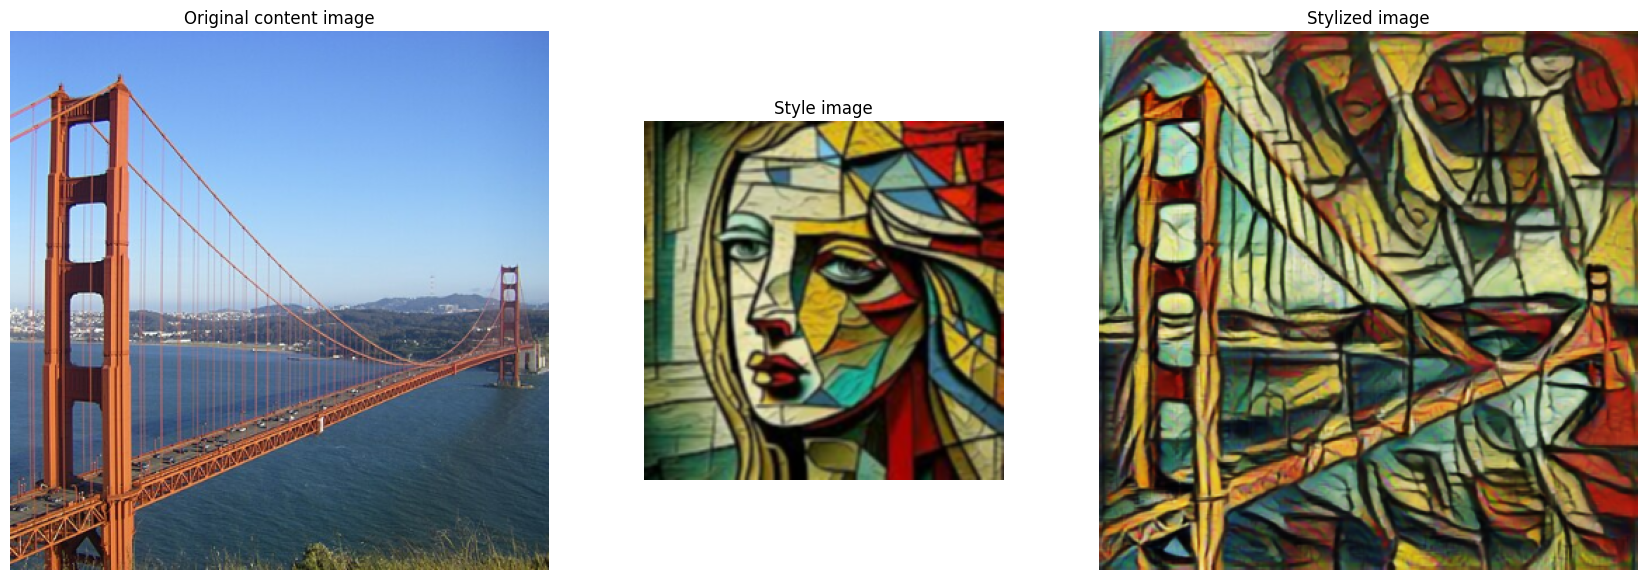

In [11]:
# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Original content image', 'Style image', 'Stylized image'])